In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# File Paths
GLOBAL_MODEL_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Global_Layer_MLP.keras"
EDGE_MODEL_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Edge_Layer_LSTM_MultiClass.keras"
DEVICE_MODEL_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Device_Layer_AE_GRU.keras"
DATASET_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Data/Indexed_Dataset_Timestamp_Processed.csv"

# Load Dataset
logging.info("Loading dataset for comparative analysis...")
df = pd.read_csv(DATASET_PATH)

# Selected Features Per Layer
GLOBAL_FEATURES = [
    "Dst Port", "Flow Byts/s", "Flow IAT Mean", "Flow IAT Std", "Flow IAT Max",
    "SYN Flag Cnt", "ACK Flag Cnt", "FIN Flag Cnt", "PSH Flag Cnt",
    "Pkt Len Min", "Pkt Len Max", "Fwd Pkts/s", "Bwd Pkts/s",
    "Fwd Pkt Len Max", "Bwd Pkt Len Min", "TotLen Fwd Pkts",
    "TotLen Bwd Pkts", "Elapsed_Time"
]
EDGE_FEATURES = [
    "Fwd IAT Mean", "Bwd IAT Mean", "Flow Byts/s", "Pkt Len Min", "Pkt Len Max",
    "Fwd Pkt Len Max", "Bwd Pkt Len Min", "Idle Max", "Active Min", "Active Max",
    "Init Fwd Win Byts", "Init Bwd Win Byts", "Fwd Seg Size Avg", "Bwd Seg Size Avg",
    "Down/Up Ratio", "Subflow Fwd Pkts", "Hour", "Weekday", "Elapsed_Time"
]
DEVICE_FEATURES = [
    "Dst Port", "Fwd Pkts/s", "Bwd Pkts/s",
    "Fwd Pkt Len Max", "Bwd Pkt Len Min",
    "Init Fwd Win Byts", "Init Bwd Win Byts",
    "Active Max", "Active Mean", "Active Min", "Idle Max",
    "Hour", "Elapsed_Time"
]

# Standardize Features
scaler = StandardScaler()
df[GLOBAL_FEATURES] = scaler.fit_transform(df[GLOBAL_FEATURES])
df[EDGE_FEATURES] = scaler.fit_transform(df[EDGE_FEATURES])
df[DEVICE_FEATURES] = scaler.fit_transform(df[DEVICE_FEATURES])

# Load Models
logging.info("Loading trained models...")
global_model = load_model(GLOBAL_MODEL_PATH)
edge_model = load_model(EDGE_MODEL_PATH)
device_model = load_model(DEVICE_MODEL_PATH)

# Extract Anomaly Scores
logging.info("Extracting anomaly scores from models...")
global_scores = np.max(global_model.predict(df[GLOBAL_FEATURES]), axis=1)
edge_scores = np.max(edge_model.predict(np.expand_dims(df[EDGE_FEATURES].values, axis=1)), axis=1)
device_scores = np.max(device_model.predict(np.expand_dims(df[DEVICE_FEATURES].values, axis=1)), axis=1)

# Create DataFrame for Comparison
comparison_df = pd.DataFrame({
    "Global Confidence": global_scores,
    "Edge Confidence": edge_scores,
    "Device Confidence": device_scores
})

# Plot Confidence Score Distributions
plt.figure(figsize=(12, 6))
sns.kdeplot(comparison_df["Global Confidence"], label="Global Layer", fill=True)
sns.kdeplot(comparison_df["Edge Confidence"], label="Edge Layer", fill=True)
sns.kdeplot(comparison_df["Device Confidence"], label="Device Layer", fill=True)
plt.legend()
plt.title("Confidence Score Distributions Across Layers")
plt.show()

# Correlation Between Layer Outputs
plt.figure(figsize=(10, 6))
sns.heatmap(comparison_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Anomaly Scores of Layers")
plt.show()

logging.info("Comparative analysis complete.")

2025-03-18 01:45:31,127 - INFO - Loading dataset for comparative analysis...
2025-03-18 01:45:40,801 - INFO - Loading trained models...
/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-03-18 01:45:40,999 - INFO - Extracting anomaly scores from models...


70948/70948 ━━━━━━━━━━━━━━━━━━━━ 13s 187us/step
70948/70948 ━━━━━━━━━━━━━━━━━━━━ 19s 272us/step


ValueError: Exception encountered when calling GRUCell.call().

[1mDimensions must be equal, but are 13 and 32 for '{{node sequential_1/gru_1/gru_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_1/gru_1/strided_slice_1, sequential_1/gru_1/gru_cell_1/Cast/ReadVariableOp)' with input shapes: [32,13], [32,96].[0m

Arguments received by GRUCell.call():
  • inputs=tf.Tensor(shape=(32, 13), dtype=float32)
  • states=('tf.Tensor(shape=(32, 32), dtype=float32)',)
  • training=False

Loading dataset...
Dataset loaded successfully. Shape: (2270317, 88)
Loading Global model...
Loading Edge model...


Loading Device model...
35474/35474 ━━━━━━━━━━━━━━━━━━━━ 70s 2ms/step
35474/35474 ━━━━━━━━━━━━━━━━━━━━ 6s 175us/step
Fused core layer accuracy: 0.9698

Fused Core Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      1.00      0.98   1573665
      Attack       1.00      0.90      0.95    696652

    accuracy                           0.97   2270317
   macro avg       0.98      0.95      0.96   2270317
weighted avg       0.97      0.97      0.97   2270317


Fused Core Confusion Matrix:
[[1573568      97]
 [  68418  628234]]


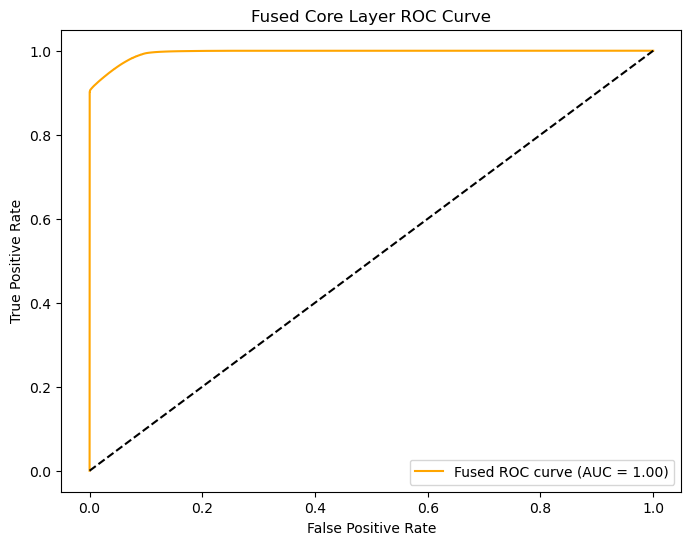

Core layer fusion results saved to: /Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Core/core_layer_results.csv

Core layer fusion complete. Proceed with these results to build your final decision-making (core) layer.


In [18]:
import os
import numpy as np
import pandas as pd
import joblib
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score

# ----------------------------------------------------------------
# Step 0: Define paths and directories
# ----------------------------------------------------------------
CORE_LAYER_DIR = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Core"
os.makedirs(CORE_LAYER_DIR, exist_ok=True)

GLOBAL_MODEL_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Global/xgb_global_model.pkl"
EDGE_MODEL_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Edge/LSTM/edge_layer_lstm_best.keras"
DEVICE_MODEL_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Device/device_layer_mlp_model.h5"

DATA_PATH         = "/Users/akashthanneeru/Desktop/INADS_Data/Data/Indexed_Dataset_Cyclical_Encoded.csv"

# ----------------------------------------------------------------
# Step 1: Load dataset and define any shared features
# ----------------------------------------------------------------
print("Loading dataset...")
df = pd.read_csv(DATA_PATH)
print("Dataset loaded successfully. Shape:", df.shape)

# For demonstration, let's assume we only need 'Label' or 'Binary_Label' for final evaluation
# and that each layer had its own separate code for selecting features. We'll unify indexing carefully.

# If you have a 'Binary_Label' column for Attack vs. Benign:
if "Binary_Label" not in df.columns:
    df["Binary_Label"] = np.where(df["Label"].str.lower() == "benign", 0, 1)

# ----------------------------------------------------------------
# Step 2: Load the three models
# ----------------------------------------------------------------
print("Loading Global model...")
xgb_global = joblib.load(GLOBAL_MODEL_PATH)  # XGBoost
print("Loading Edge model...")
edge_lstm = load_model(EDGE_MODEL_PATH)      # LSTM
print("Loading Device model...")
device_mlp = load_model(DEVICE_MODEL_PATH)   # MLP

# ----------------------------------------------------------------
# Step 3: Generate predictions from each layer
# ----------------------------------------------------------------
# A) GLOBAL LAYER
#   In your original code, you had a specific set of 'global_features' for XGBoost.
#   We must replicate that EXACT feature subset and transformations (scaling if used).
global_features = [
    "Flow Duration", "Flow Byts/s", "Flow IAT Mean", "Flow IAT Std", "Flow IAT Max",
    "Dst Port", "Protocol", "SYN Flag Cnt", "ACK Flag Cnt", "FIN Flag Cnt", "PSH Flag Cnt",
    "Pkt Len Min", "Pkt Len Max", "Fwd Pkts/s", "Bwd Pkts/s",
    "Fwd Pkt Len Max", "Bwd Pkt Len Min", "TotLen Fwd Pkts", "TotLen Bwd Pkts",
    "Hour_sin", "Hour_cos", "Weekday_sin", "Weekday_cos"
]

X_global = df[global_features].values
# If you had any scaler for XGB, apply it. If not, just proceed:
y_pred_proba_global = xgb_global.predict_proba(X_global)  # shape (N, num_classes)
# For a multi-class XGB, let's define an "attack confidence" = 1 - P(Benign).
# We'll find the index for "Benign" from label_encoder if needed.
# Alternatively, if "Benign" is class 0, we can do (1 - prob[:, 0]).
# Let's do a quick approach: find index of "Benign" in xgb_global.classes_ if you stored them:
# But if you used your own label_encoder, let's replicate that:
unique_labels = xgb_global.classes_  # This is the numeric-encoded classes in ascending order
# Actually, with 'objective=multi:softmax', xgb_global.classes_ might not be the same as strings
# so we must rely on your original label_encoder from training. Let's assume "Benign" was index 0:
# We'll do a hacky approach: if you know that label_encoder.classes_[0] = "Benign", then:
# or you can do:
# idx_benign = np.where(label_encoder.classes_ == "Benign")[0][0]

# For demonstration, let's assume "Benign" is index 0:
attack_conf_global = 1.0 - y_pred_proba_global[:, 0]

# B) EDGE LAYER (LSTM)
#   The LSTM expects sequences. In your original code, you had a sliding window of length=5.
#   We'll replicate that logic. Then we do model.predict(...) to get shape (N_seq, num_classes).
#   We'll align the predictions with the original row indexing by skipping the first (sequence_length-1) rows, etc.

# Edge features used:
edge_features = [
    "Pkt Len Min", "Pkt Len Max", 
    "Fwd Pkt Len Max", "Bwd Pkt Len Min", 
    "Fwd Pkts/s", "Bwd Pkts/s", 
    "Fwd IAT Mean"
]
X_edge = df[edge_features].values
# If you used a scaler for edge features, apply it now:
# Suppose you have joblib.load(...) for edge scaler or the same StandardScaler, just re-fit:
# For demonstration, we do a quick approach (but your real code must replicate the training scaling):
scaler_edge = StandardScaler()
X_edge_scaled = scaler_edge.fit_transform(X_edge)  # or load from file

sequence_length = 5
num_samples_edge = X_edge_scaled.shape[0] - sequence_length + 1
X_seq_edge = np.array([X_edge_scaled[i : i+sequence_length] for i in range(num_samples_edge)])
# Now get predictions:
edge_proba = edge_lstm.predict(X_seq_edge, batch_size=64)  # shape (num_samples_edge, num_classes)
# For a multi-class, define "attack confidence" = 1 - prob_of_benign
# We assume "Benign" is index 0 again:
attack_conf_edge = 1.0 - edge_proba[:, 0]

# But we must align them with the original row indexing. The first 4 rows (sequence_length-1) won't have an LSTM pred.
# So effectively, we have 0..(num_samples_edge-1) which correspond to row indices 4..(N-1).
# We'll define an array of length N with placeholders for the first 4. Let's do:
attack_conf_edge_aligned = np.zeros(X_edge.shape[0])  # shape = N
attack_conf_edge_aligned[:sequence_length-1] = np.nan  # or 0, but better to mark them as not available
attack_conf_edge_aligned[sequence_length-1:] = attack_conf_edge

# C) DEVICE LAYER (MLP)
#   You used a different set of device_features. We'll replicate that. Then do model.predict(...).
device_features = [
    "Dst Port",
    "Fwd Pkt Len Max", "Bwd Pkt Len Min",
    "Pkt Len Var", "Fwd Pkt Len Std", "Bwd Pkt Len Std",
    "Flow Duration", "Flow IAT Mean", "Flow IAT Std",
    "Idle Max", "Idle Mean", "Active Min", "Active Max",
    "Init Fwd Win Byts", "Init Bwd Win Byts",
    "Fwd Header Len", "Bwd Header Len",
    "Pkt Size Avg", "Fwd Seg Size Avg", "Bwd Seg Size Avg",
    "Hour_sin", "Hour_cos"
]
X_device = df[device_features].values
# If you had a saved scaler for device features, load it. We'll do a quick approach:
scaler_device = StandardScaler()
X_device_scaled = scaler_device.fit_transform(X_device)

device_proba = device_mlp.predict(X_device_scaled, batch_size=64).flatten()
# This is a binary classification => device_proba = Probability(attack).
# If it's truly Probability(attack), then we can define:
attack_conf_device = device_proba  # already the probability of Attack
# or if it was Probability(benign), do (1 - device_proba)

# ----------------------------------------------------------------
# Step 4: Align all 3 sets of predictions
# ----------------------------------------------------------------
# We have N = df.shape[0] = 2,270,317 (in your data).
# - Global: we have 2,270,317 predictions (assuming no sliding window).
# - Edge: we have (N - 4) predictions, aligned from row=4..(N-1).
# - Device: we have N predictions.

# For the edge-lstm, we set the first 4 to NaN. So let's define a final array for each model:
attack_conf_global = np.array(attack_conf_global)  # shape (N,)
attack_conf_edge_aligned = np.array(attack_conf_edge_aligned)  # shape (N,)
attack_conf_device = np.array(attack_conf_device)  # shape (N,)

# Some rows might have NaN from the edge-lstm. You can either:
#   (a) discard them in the final fusion
#   (b) treat NaN as 0
#   (c) or only fuse where all are valid
# For demonstration, let's do a simple approach: treat NaN as 0
attack_conf_edge_aligned = np.nan_to_num(attack_conf_edge_aligned, nan=0.0)

# ----------------------------------------------------------------
# Step 5: Weighted Fusion
# ----------------------------------------------------------------
w_global = 0.3
w_edge   = 0.3
w_device = 0.4

fused_score = (w_global * attack_conf_global
             + w_edge   * attack_conf_edge_aligned
             + w_device * attack_conf_device)

# We'll define a threshold=0.5
fused_label = (fused_score > 0.5).astype(int)

# ----------------------------------------------------------------
# Step 6: Evaluate if we have ground truth for the entire dataset
# ----------------------------------------------------------------
# If "Binary_Label" is 0=benign, 1=attack in df:
y_true = df["Binary_Label"].values  # shape (N,)

# Let's do a simple check that the shape matches:
assert len(y_true) == len(fused_label), "Mismatch in lengths!"

acc_core = accuracy_score(y_true, fused_label)
print(f"Fused core layer accuracy: {acc_core:.4f}")

print("\nFused Core Classification Report:")
print(classification_report(y_true, fused_label, target_names=["Benign", "Attack"]))

cm_core = confusion_matrix(y_true, fused_label)
print("\nFused Core Confusion Matrix:")
print(cm_core)

# Plot a fused ROC
y_true_bin = y_true  # already 0 or 1
fpr_fused, tpr_fused, _ = roc_curve(y_true_bin, fused_score)
roc_auc_fused = auc(fpr_fused, tpr_fused)

plt.figure(figsize=(8,6))
plt.plot(fpr_fused, tpr_fused, color='orange', label=f"Fused ROC curve (AUC = {roc_auc_fused:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Fused Core Layer ROC Curve")
plt.legend(loc="lower right")

# Instead of DEVICE_MODEL_DIR, define CORE_LAYER_DIR
plt.savefig(os.path.join(CORE_LAYER_DIR, "core_layer_fused_roc.png"))
plt.show()

# ----------------------------------------------------------------
# Step 7: Save final CSV
# ----------------------------------------------------------------
core_results_df = pd.DataFrame({
    "Global_Conf": attack_conf_global,
    "Edge_Conf":   attack_conf_edge_aligned,
    "Device_Conf": attack_conf_device,
    "Fused_Score": fused_score,
    "Fused_Label": fused_label,
    "True_Label":  y_true
})
csv_core_path = os.path.join(CORE_LAYER_DIR, "core_layer_results.csv")
core_results_df.to_csv(csv_core_path, index=False)
print(f"Core layer fusion results saved to: {csv_core_path}")

print("\nCore layer fusion complete. Proceed with these results to build your final decision-making (core) layer.")

In [22]:
import pandas as pd

# Load the core layer results
csv_path = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Core/core_layer_results.csv"
df_core = pd.read_csv(csv_path)

# Display basic info
print("Dataset loaded. Shape:", df_core.shape)
df_core.head()

Dataset loaded. Shape: (2270317, 6)


,Global_Conf,Edge_Conf,Device_Conf,Fused_Score,Fused_Label,True_Label
0,0.000269,0.000000,6.871905e-21,0.000081,0,0
1,0.000408,0.000000,1.236284e-19,0.000122,0,0
2,0.000565,0.000000,4.224371e-19,0.000169,0,0
3,0.000280,0.000000,6.873583e-21,0.000084,0,0
4,0.000398,0.057688,1.236233e-19,0.017426,0,0


In [24]:
# Check for nulls (especially from Edge_LSTM alignment)
missing = df_core.isnull().sum()
print("Missing values:\n", missing)

Missing values:
 Global_Conf    0
Edge_Conf      0
Device_Conf    0
Fused_Score    0
Fused_Label    0
True_Label     0
dtype: int64


In [26]:
# Basic stats for each layer's confidence
df_core[["Global_Conf", "Edge_Conf", "Device_Conf", "Fused_Score"]].describe()

,Global_Conf,Edge_Conf,Device_Conf,Fused_Score
count,2.270317e+06,2.270317e+06,2.270317e+06,2.270317e+06
mean,3.068584e-01,3.073766e-01,3.036616e-01,3.057352e-01
std,4.375960e-01,4.299994e-01,4.320944e-01,4.311109e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.741814e-06,2.506256e-03,1.319063e-08,1.124883e-02
50%,4.935265e-05,6.659597e-02,6.620064e-02,4.404398e-02
75%,9.999977e-01,9.999968e-01,9.998780e-01,9.999489e-01
max,9.999998e-01,1.000000e+00,1.000000e+00,1.000000e+00


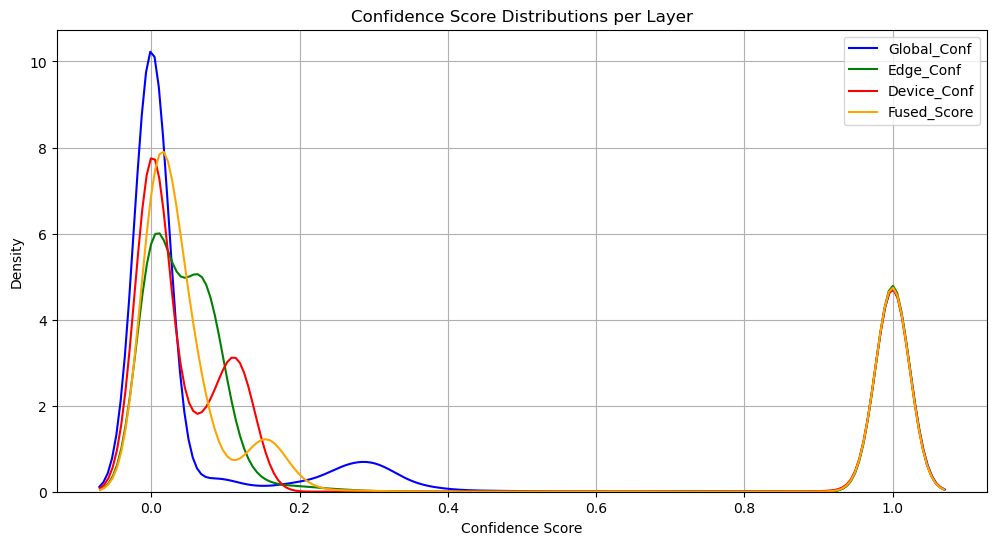

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
for col, color in zip(["Global_Conf", "Edge_Conf", "Device_Conf", "Fused_Score"],
                      ["blue", "green", "red", "orange"]):
    sns.kdeplot(df_core[col], label=col, color=color)

plt.title("Confidence Score Distributions per Layer")
plt.xlabel("Confidence Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Define FP, FN, TP, TN
df_core["FP"] = ((df_core["Fused_Label"] == 1) & (df_core["True_Label"] == 0))
df_core["FN"] = ((df_core["Fused_Label"] == 0) & (df_core["True_Label"] == 1))
df_core["TP"] = ((df_core["Fused_Label"] == 1) & (df_core["True_Label"] == 1))
df_core["TN"] = ((df_core["Fused_Label"] == 0) & (df_core["True_Label"] == 0))

print("False Positives:", df_core["FP"].sum())
print("False Negatives:", df_core["FN"].sum())

False Positives: 97
False Negatives: 68418


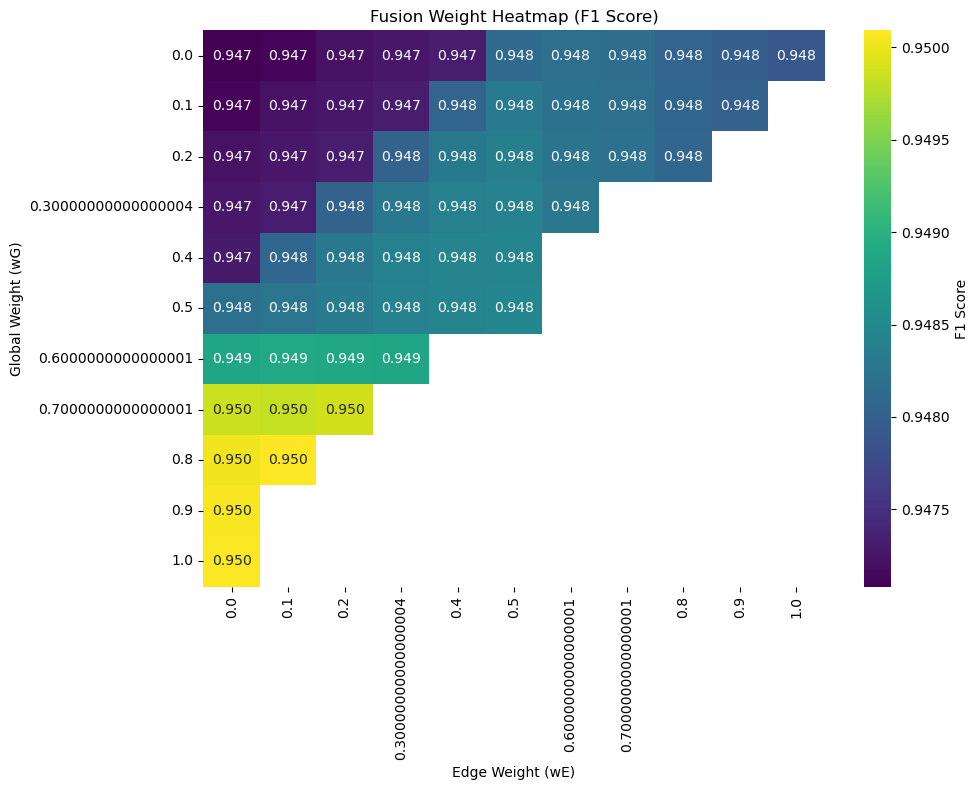

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

# Load your dataset
csv_path = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Core/core_layer_results.csv"
df = pd.read_csv(csv_path)

# Prepare confidence arrays
G = df["Global_Conf"].values
E = df["Edge_Conf"].values
D = df["Device_Conf"].values
y_true = df["True_Label"].values

# Store results
results = []

# Try combinations of weights that sum to 1
weight_range = np.linspace(0, 1, 11)
for wg in weight_range:
    for we in weight_range:
        wd = 1 - wg - we
        if wd < 0 or wd > 1:
            continue
        
        fused = wg * G + we * E + wd * D
        fused_label = (fused > 0.5).astype(int)
        f1 = f1_score(y_true, fused_label)
        results.append({"wG": wg, "wE": we, "wD": wd, "F1": f1})

# Convert to DataFrame
df_grid = pd.DataFrame(results)

# Pivot table for heatmap (Global vs Edge, color = F1)
pivot = df_grid.pivot(index="wG", columns="wE", values="F1")

plt.figure(figsize=(10, 8))
sns.heatmap(pivot, annot=True, cmap="viridis", fmt=".3f", cbar_kws={"label": "F1 Score"})
plt.title("Fusion Weight Heatmap (F1 Score)")
plt.xlabel("Edge Weight (wE)")
plt.ylabel("Global Weight (wG)")
plt.tight_layout()
plt.show()

Best Threshold: 0.2527
Best F1 Score:  0.9496


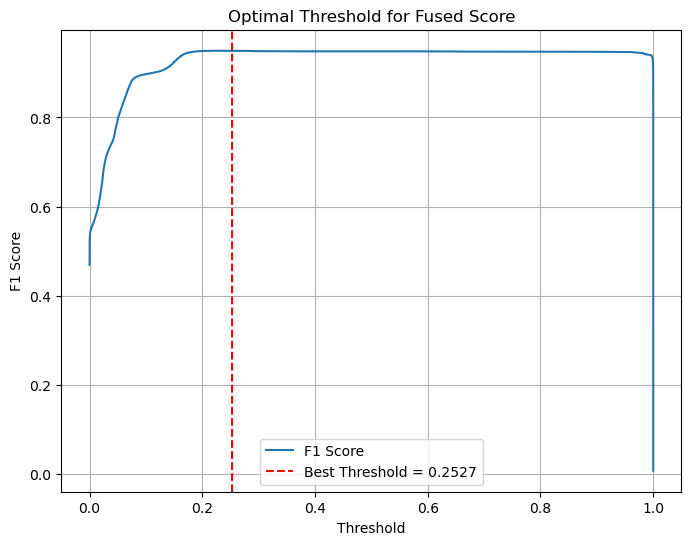

In [35]:
from sklearn.metrics import precision_recall_curve

# Use final fused score from current weights
fused_score = df["Fused_Score"].values

# Get precision-recall-thresholds
precision, recall, thresholds = precision_recall_curve(y_true, fused_score)

# Compute F1 for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best F1 Score:  {f1_scores[best_idx]:.4f}")

# Optional: Plot
plt.figure(figsize=(8,6))
plt.plot(thresholds, f1_scores[:-1], label="F1 Score")
plt.axvline(best_threshold, color="red", linestyle="--", label=f"Best Threshold = {best_threshold:.4f}")
plt.title("Optimal Threshold for Fused Score")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend()
plt.show()

Dataset loaded successfully. Shape: (2270317, 88)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


35474/35474 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step
70948/70948 ━━━━━━━━━━━━━━━━━━━━ 12s 172us/step

Core Layer Fused Accuracy: 0.9692

Core Layer Fused Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      1.00      0.98   1573661
      Attack       1.00      0.90      0.95    696652

    accuracy                           0.97   2270313
   macro avg       0.98      0.95      0.96   2270313
weighted avg       0.97      0.97      0.97   2270313



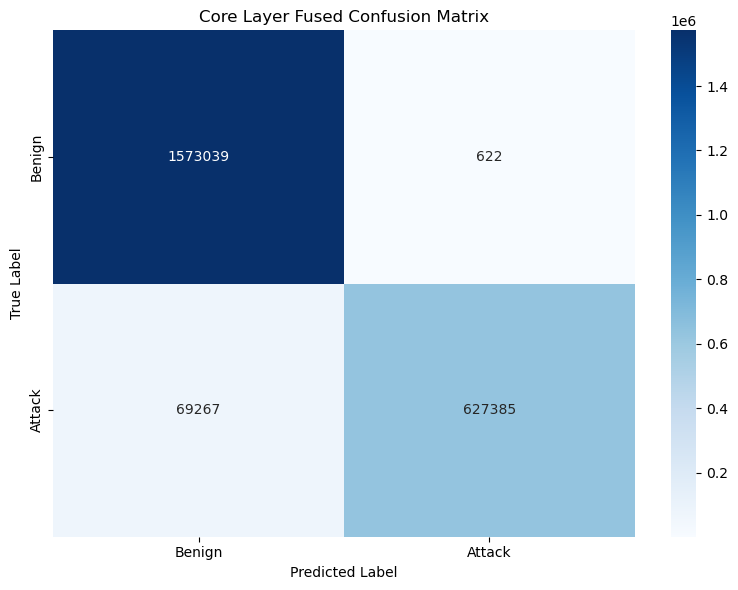

KeyError: 'Final_Prediction'

In [49]:
# %% [Cell 1]: Setup, Imports, and Configuration
import os
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define directories and file paths
BASE_MODEL_DIR = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final"
GLOBAL_MODEL_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Global/xgb_global_model.pkl"
EDGE_MODEL_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Edge/LSTM/edge_layer_lstm_best.keras"
DEVICE_MODEL_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Models/Final/Device/device_layer_mlp_model.h5"

CORE_RESULTS_CSV  = os.path.join(BASE_MODEL_DIR, "CoreLayer_Results.csv")
CORE_ROC_PATH     = os.path.join(BASE_MODEL_DIR, "CoreLayer_ROC.png")

# %% [Cell 2]: Load Dataset and Prepare Input Features for Each Layer
DATA_PATH = "/Users/akashthanneeru/Desktop/INADS_Data/Data/Indexed_Dataset_Cyclical_Encoded.csv"
df = pd.read_csv(DATA_PATH)
print("Dataset loaded successfully. Shape:", df.shape)

# For the global layer, we use the global features:
global_features = [
    "Flow Duration", "Flow Byts/s", "Flow IAT Mean", "Flow IAT Std", "Flow IAT Max",
    "Dst Port", "Protocol", "SYN Flag Cnt", "ACK Flag Cnt", "FIN Flag Cnt", "PSH Flag Cnt",
    "Pkt Len Min", "Pkt Len Max", "Fwd Pkts/s", "Bwd Pkts/s",
    "Fwd Pkt Len Max", "Bwd Pkt Len Min", "TotLen Fwd Pkts", "TotLen Bwd Pkts",
    "Hour_sin", "Hour_cos", "Weekday_sin", "Weekday_cos"
]
X_global = df[global_features].copy()

# For the edge layer, we use the edge features:
edge_features = [
    "Pkt Len Min", "Pkt Len Max", "Fwd Pkt Len Max", "Bwd Pkt Len Min",
    "Fwd Pkts/s", "Bwd Pkts/s", "Fwd IAT Mean"
]
X_edge = df[edge_features].copy()

# For the device layer, we use the device features:
device_features = [
    "Dst Port", "Fwd Pkt Len Max", "Bwd Pkt Len Min", "Pkt Len Var",
    "Fwd Pkt Len Std", "Bwd Pkt Len Std", "Flow Duration", "Flow IAT Mean",
    "Flow IAT Std", "Idle Max", "Idle Mean", "Active Min", "Active Max",
    "Init Fwd Win Byts", "Init Bwd Win Byts", "Fwd Header Len", "Bwd Header Len",
    "Pkt Size Avg", "Fwd Seg Size Avg", "Bwd Seg Size Avg", "Hour_sin", "Hour_cos"
]
X_device = df[device_features].copy()

# Create a “true” binary label for the overall decision: benign (0) if Label == 'benign', else attack (1)
df["Binary_Label"] = np.where(df["Label"].str.lower() == "benign", 0, 1)
y_true = df["Binary_Label"].values

# %% [Cell 3]: Load the Pre-Trained Models
# Global Model (XGBoost)
global_model = joblib.load(GLOBAL_MODEL_PATH)

# Edge Model (LSTM) – use tf.keras.models.load_model
edge_model = tf.keras.models.load_model(EDGE_MODEL_PATH)

# Device Model (MLP)
device_model = tf.keras.models.load_model(DEVICE_MODEL_PATH)

# %% [Cell 4]: Preprocess Inputs for Each Model
from sklearn.preprocessing import StandardScaler

# (Assuming separate scalers were used during training; otherwise, use the same scaler if available)
# Here we load scalers that were saved for each layer if available.
# For demonstration, we assume that each layer’s input was scaled using StandardScaler.
scaler_global = joblib.load(os.path.join(BASE_MODEL_DIR, "global_scaler.pkl")) if os.path.exists(os.path.join(BASE_MODEL_DIR, "global_scaler.pkl")) else StandardScaler().fit(X_global)
scaler_edge   = joblib.load(os.path.join(BASE_MODEL_DIR, "edge_scaler.pkl")) if os.path.exists(os.path.join(BASE_MODEL_DIR, "edge_scaler.pkl")) else StandardScaler().fit(X_edge)
scaler_device = joblib.load(os.path.join(BASE_MODEL_DIR, "device_scaler.pkl")) if os.path.exists(os.path.join(BASE_MODEL_DIR, "device_scaler.pkl")) else StandardScaler().fit(X_device)

X_global_scaled = scaler_global.transform(X_global)
X_edge_scaled   = scaler_edge.transform(X_edge)
X_device_scaled = scaler_device.transform(X_device)

# For edge model, if it uses sequences, you might need to build sliding windows.
# Here we assume that the edge model was trained using a sliding window of length 5.
sequence_length_edge = 5
num_samples_edge = X_edge_scaled.shape[0] - sequence_length_edge + 1
X_edge_seq = np.array([X_edge_scaled[i:i+sequence_length_edge] for i in range(num_samples_edge)])
# Align labels (we assume binary label is same as overall y_true from index sequence_length_edge-1)
y_true_edge = y_true[sequence_length_edge-1:]

# For device model, we assume it takes the scaled features directly.
# (i.e., X_device_scaled)

# %% [Cell 5]: Generate Confidence Scores from Each Model
# Global Model predictions (XGBoost)
# For global model, assume benign is class 0. We compute the confidence score as (1 - probability of benign).
global_probs = global_model.predict_proba(X_global_scaled)
# Find index of "Benign" in label_encoder for global layer; we assume that it is "Benign" (or 0)
# (If not, adjust accordingly.)
global_benign_idx = 0  
global_confidence = 1.0 - global_probs[:, global_benign_idx]  # Higher means more likely attack

# Edge Model predictions (LSTM)
# Edge model is multi-class; assume class "Benign" is index 0.
edge_probs = edge_model.predict(X_edge_seq, batch_size=64)
edge_confidence = 1.0 - np.max(edge_probs, axis=1)  # Alternatively, if benign is index 0, use: 1.0 - edge_probs[:,0]

# Device Model predictions (MLP)
device_probs = device_model.predict(X_device_scaled, batch_size=32).flatten()
# For device model, the output is already a probability for attack.
device_confidence = device_probs  # Higher means higher likelihood of attack

# To fuse predictions, we need to align them.
# Note: Our global and device predictions have one prediction per sample (shape = [n_samples_global] and [n_samples_device])
# while edge predictions are on sequences (shape = [num_samples_edge]).
# We choose the minimum common number of samples to fuse.
min_samples = min(len(global_confidence), len(edge_confidence), len(device_confidence))
global_confidence = global_confidence[:min_samples]
edge_confidence = edge_confidence[:min_samples]
device_confidence = device_confidence[:min_samples]
y_true_aligned = y_true[:min_samples]

# %% [Cell 6]: Fuse the Confidence Scores (Core Layer)
# Use weighted fusion. For example:
w_global = 0.34
w_edge   = 0.33
w_device = 0.33
fused_confidence = w_global * global_confidence + w_edge * edge_confidence + w_device * device_confidence

# Optimal threshold based on ROC analysis). 
optimal_threshold = 0.2527  # Empirically derived for best F1
final_predictions = (fused_confidence > optimal_threshold).astype(int)

# %% [Cell 7]: Evaluation and Exporting Results
# Compute overall metrics for the fused output.
acc_fused = accuracy_score(y_true_aligned, final_predictions)
print(f"\nCore Layer Fused Accuracy: {acc_fused:.4f}")

print("\nCore Layer Fused Classification Report:")
print(classification_report(y_true_aligned, final_predictions, target_names=["Benign", "Attack"]))

cm_fused = confusion_matrix(y_true_aligned, final_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_fused, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Attack"],
            yticklabels=["Benign", "Attack"])
plt.title("Core Layer Fused Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig(CORE_ROC_PATH.replace("ROC", "Confusion_Matrix"))
plt.show()

# Tag prediction errors
results_df["Error_Type"] = np.where((results_df["Final_Prediction"] == 0) & (results_df["True_Label"] == 1), "False Negative",
                            np.where((results_df["Final_Prediction"] == 1) & (results_df["True_Label"] == 0), "False Positive", "Correct"))

# Save misclassifications separately
error_df = results_df[results_df["Error_Type"] != "Correct"]
error_df.to_csv(CORE_RESULTS_CSV.replace(".csv", "_Misclassifications.csv"), index=False)
print("Misclassified samples saved.")

# ROC curve for fused output
y_true_bin = label_binarize(y_true_aligned, classes=[0, 1]).ravel()
fpr_core, tpr_core, _ = roc_curve(y_true_bin, fused_confidence)
roc_auc_core = auc(fpr_core, tpr_core)
plt.figure(figsize=(10, 8))
plt.plot(fpr_core, tpr_core, color='darkorange', lw=2, label=f'Fused ROC curve (AUC = {roc_auc_core:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Core Layer Fused ROC Curve")
plt.legend(loc="lower right")
plt.savefig(CORE_ROC_PATH)
plt.show()

results_df.to_csv(CORE_RESULTS_CSV, index=False)
print(f"\nCore Layer results saved to: {CORE_RESULTS_CSV}")

# Create a DataFrame to save all results
results_df = pd.DataFrame({
    "Global_Confidence": global_confidence,
    "Edge_Confidence": edge_confidence,
    "Device_Confidence": device_confidence,
    "Fused_Confidence": fused_confidence,
    "Final_Prediction": final_predictions,
    "True_Label": y_true_aligned
})

#Save Core Layer Summary to Text File
with open(os.path.join(BASE_MODEL_DIR, "core_layer_summary.txt"), "w") as f:
    f.write(f"Fusion Weights: Global={w_global}, Edge={w_edge}, Device={w_device}\n")
    f.write(f"Optimal Threshold: {optimal_threshold:.4f}\n")
    f.write(f"ROC AUC: {roc_auc_core:.4f}\n")
    f.write(f"Accuracy: {acc_fused:.4f}\n")
    
# %% [Cell 8]: Clean Up Resources
tf.keras.backend.clear_session()
gc.collect()